# DDPM
Visualizing the noising and denoising process with the FashionMNIST dataset — with class-conditional generation.

In [ ]:
import torch
import torch.nn.functional as F
from torch import optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# --- Set up device. If you don't have a GPU, consider using Google Colab ---
device = "cpu"
if torch.cuda.is_available(): #Use this if you have a CUDA-compatible GPU (e.g. Nvidida)
    device = "cuda"
elif torch.backends.mps.is_available(): #Use this if you have a Mac with M1/M2/M3/M4 chip
    device = "mps"
print(f"Using device: {device}")

In [ ]:
# cell to clone the repo for data and demo html on colab
!git clone -b week2-fashion-magazine-notebook https://github.com/eth-bmai-fs26/project.git
!git fetch && git checkout week2-fashion-magazine-notebook
%cd project/week2/notebook

Load and preprocess the FashionMNIST dataset.

In [ ]:
# --- Define transformations
# Transform to tensor and normalize dataset to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # (mean, std) for single channel
])

# FashionMNIST class names (label index -> clothing category)
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
NUM_CLASSES = len(CLASS_NAMES)

# --- Load FashionMNIST and create DataLoader (all 10 classes)
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

batch_size = 1024
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Let's look at one image to confirm
image, label = train_dataset[0]
print("Image shape:", image.shape)
print(f"Label: {label} ({CLASS_NAMES[label]})")
print(f"Pixel value range: {image.min()} to {image.max()}")

In [ ]:
"""
Show one example image for each of the 10 FashionMNIST classes.
"""
# Collect the first occurrence of every class
class_images = {}
for img, lbl in train_dataset:
    if lbl not in class_images:
        class_images[lbl] = img.squeeze(0)
    if len(class_images) == NUM_CLASSES:
        break

fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(15, 1.8))
for cls_idx, ax in enumerate(axes):
    ax.imshow(class_images[cls_idx], cmap="gray")
    ax.set_title(CLASS_NAMES[cls_idx], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Forward diffusion process

Remember the formula for the forward diffusion process:

$$X_{i} = \sqrt{\bar{\alpha}_{i}} \, X_{0} + \sqrt{1-\bar{\alpha}_{i}} \, \varepsilon, \;\;\; \varepsilon \sim \mathcal{N}(0,I).$$

In [ ]:
# Hyperparameters for the diffusion process
TIMESTEPS = 800
beta_start = 0.0001
beta_end = 0.02

# Define the beta schedule (variance)
betas = torch.linspace(beta_start, beta_end, TIMESTEPS, device=device)

# Pre-calculate alphas and other values for the formula
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0) # Computes comulative product of alphas

sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)

# The Forward Noising Function
def add_noise(x_0, t):
    """
    Applies noise to an image x_0 at a specific timestep t.
    """
    # Sample random noise from a standard Gaussian
    noise = torch.randn_like(x_0)

    # Get the pre-calculated values for the given timesteps
    sqrt_alphas_bar_t = get_values_at_timestep(sqrt_alphas_bar, t)
    sqrt_one_minus_alphas_bar_t = get_values_at_timestep(sqrt_one_minus_alphas_bar, t)

    # Apply the formula to get the noisy image
    x_t = sqrt_alphas_bar_t * x_0 + sqrt_one_minus_alphas_bar_t * noise
    return x_t, noise

# Helper function to get the correct values for a batch of timesteps
def get_values_at_timestep(values, t):
    """
    Gathers the values from the `values` tensor at the indices specified by `t`.
    Reshapes the output to be compatible for broadcasting with image tensors.
    """
    batch_size = t.shape[0]
    # Gather values and reshape to (batch_size, 1, 1, 1) for broadcasting
    return values.gather(-1, t).reshape(batch_size, 1, 1, 1)

Visualizing the noising process:

In [ ]:
# Helper function to display images
def show_images(images, titles=None, grid=False):
    images = (images + 1) / 2
    images = images.clamp(0, 1)

    if grid:
        cols = 4
        rows = (len(images) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        axs = axs.flatten() if rows > 1 else (axs if cols > 1 else [axs])
        for i, ax in enumerate(axs):
            if i < len(images):
                ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
                if titles and i < len(titles):
                    ax.set_title(titles[i])
            ax.axis('off')
    else:
        fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
        for i, img in enumerate(images):
            axs[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
            axs[i].axis('off')
            if titles:
                axs[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

Visualizing the forward noising process:


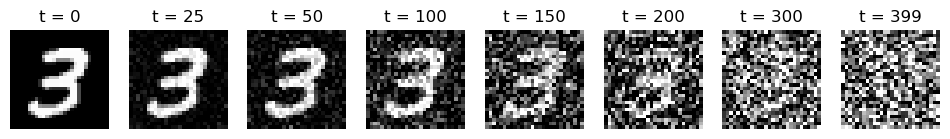

In [ ]:
# Visualization of the forward pass
image, _ = train_dataset[0] # Get first image
image = image.to(device).unsqueeze(0) # Add batch dimension and move to device

num_steps = 10  # Number of noise levels to visualize
vis_timesteps = torch.linspace(0, TIMESTEPS - 1, num_steps).long().tolist()
noisy_images = []
titles = []

# Generate noisy images at specified timesteps
for timestep in vis_timesteps:
    noisy_img, _ = add_noise(image, torch.tensor([timestep], device=device))
    noisy_images.append(noisy_img)
    titles.append(f"t = {timestep}")

print("Visualizing the forward noising process:")
show_images(torch.cat(noisy_images, dim=0), titles=titles)

# Reverse diffusion process. Learn to predict the noise.

Train a UNet model to predict the noise:

In [ ]:
from unet import SimpleUNet

# --- Initialize the model which we use to predict the score function.
score_model = SimpleUNet(base_ch=64, emb_dim=64, num_classes=NUM_CLASSES).to(device) #Set base_ch to 16 if this takes too long on your laptop
score_model.train()
optimizer = optim.AdamW(score_model.parameters(), lr=1e-4)

# --- Training loop, learning to reverse the noise. ---
epochs = 20

for epoch in range(1, epochs + 1):
    for x_0, labels in train_loader: # CHANGE 2: unpack labels alongside images
        optimizer.zero_grad(set_to_none=True)
        x_0 = x_0.to(device)
        labels = labels.to(device)  # CHANGE 2: move labels to device
        batch_dimension = x_0.size(0)
        t = torch.randint(0, TIMESTEPS, (batch_dimension,), device=device).long() # choose random timestep for every sample from the input

        # Add noise using the forward process
        x_t, noise = add_noise(x_0, t)

        # Predict the added noise, conditioned on the class label
        predicted_noise = score_model(x_t, t, labels)  # CHANGE 2: pass labels to model

        # Learn to reverse the noise
        loss = F.mse_loss(predicted_noise, noise)

        # Take an optimization step
        loss.backward()
        optimizer.step()

    if epoch%5 == 0:
        print(f"Finished epoch {epoch}. Current loss: loss={loss.item():.4f}")

print("Training is finished!")

Remember the mean and variance for the backward diffusion process:

   $$\mu(x_i) = \frac{1}{\sqrt{\alpha_i}} \left( x_i - \frac{1-\alpha_i}{\sqrt{1 - \bar{\alpha}_{i}}} \bar{\varepsilon}_{i} \right)$$

   $$\sigma^{2}(i) = \frac{(1 - \alpha_{i}) (1 - \bar{\alpha}_{i-1})}{1 - \bar{\alpha}_{i}},$$

Which are then used for the closed form equation for the backward diffusion process:

   $$x_{i-1} = \frac{1}{\sqrt{\alpha_i}} \left( x_i - \frac{1-\alpha_i}{\sqrt{1 - \bar{\alpha}_{i}}} \bar{\varepsilon}_{i} \right) + \sigma(i) z.$$

In [8]:
# Precompute helpful buffers for sampling
alphas_bar_previous = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]], dim=0)
sqrt_alphas_inverse = torch.sqrt(1.0 / alphas)
inverse_sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

# Posterior mean coefficient
coef_eps = (1 - alphas) / inverse_sqrt_one_minus_alphas_bar

# Posterior variance
posterior_variance = (1 - alphas) * (1 - alphas_bar_previous) / (1 - alphas_bar)
posterior_log_variance_clipped = torch.log(torch.clamp(posterior_variance, min=1e-20))

In [ ]:
@torch.no_grad()
def sample(score_model, num_samples=16, class_label=0):
    score_model.eval()
    # Start from random noise
    x_t = torch.randn(num_samples, 1, 28, 28, device=device)

    # Class label tensor — same label for all samples in this batch
    labels = torch.full((num_samples,), class_label, device=device, dtype=torch.long)

    # Now we reverse the noising
    for timestep in reversed(range(TIMESTEPS)):
        t = torch.full((num_samples,), timestep, device=device, dtype=torch.long)

        # Denoising, conditioned on the class label
        mean = (x_t - coef_eps[timestep] * score_model(x_t, t, labels)) * sqrt_alphas_inverse[timestep]

        if timestep > 0:
            #Add noise for sample diversity
            noise = torch.randn_like(x_t)
            var = posterior_variance[timestep]
            x_t = mean + torch.sqrt(var) * noise
        else:
            x_t = mean
    return x_t

num_samples = 16
class_label = 0 # tshirt

# Generate samples conditioned on the chosen class
samples = sample(score_model, num_samples=num_samples, class_label=class_label)

# unnormalize back to [0,1] for display
samples = (samples.clamp(-1, 1) + 1) / 2.0

print(f"16 samples of class {class_label}: '{CLASS_NAMES[class_label]}'.")
show_images(samples[:num_samples].cpu(), titles=[CLASS_NAMES[class_label] for _ in range(num_samples)], grid=True)

In [ ]:
@torch.no_grad()
def denoising_process_single_sample(
    score_model,
    class_label: int = 0,                         # which class to generate
    record_timesteps: list[int] | None = None,    # which t to keep (e.g., [TIMESTEPS-1,...,0]); None = keep all
):
    score_model.eval()

    x_t = torch.randn(1, 1, 28, 28, device=device)
    start_t = TIMESTEPS - 1

    # Class label tensor (batch size 1)
    labels = torch.tensor([class_label], device=device, dtype=torch.long)

    record_set = set(record_timesteps) if record_timesteps is not None else None
    trace = []

    # Optionally record the starting x_T
    if record_set is None or start_t in record_set:
        trace.append((start_t, x_t.detach().clone()))

    for timestep in reversed(range(TIMESTEPS)):
        t = torch.full((1,), timestep, device=device, dtype=torch.long)

        # mean term: (x - coef_eps_i * eps_theta) / sqrt(alpha_i), conditioned on class
        mean = (x_t - coef_eps[timestep] * score_model(x_t, t, labels)) * sqrt_alphas_inverse[timestep]

        if timestep > 0:
            noise = torch.randn_like(x_t)
            var = posterior_variance[timestep]
            x_t = mean + torch.sqrt(var) * noise
        else:
            x_t = mean  # final step has no noise

        if record_set is None or timestep in record_set:
            trace.append((timestep, x_t.detach().clone()))

    # trace is in descending t order already (T-1 -> 0)
    return x_t, trace

# ---- Example usage: record specific timesteps to mirror your forward viz ----
vis_timesteps = torch.linspace(TIMESTEPS - 1, 0, 10).long().tolist()
class_label = 2

# Run reverse sampling for one sample and keep only those steps
x0, trace = denoising_process_single_sample(score_model, class_label=class_label, record_timesteps=vis_timesteps)

# Prepare images (ordered by vis_timesteps for consistent titles)
# trace is a list of (t, x_t); convert to dict for quick indexing
trace_dict = {t: x_t for (t, x_t) in trace}
imgs = []
titles = []
for t_val in vis_timesteps:
    x_t = trace_dict[t_val]
    # unnormalize from [-1,1] to [0,1] for display
    x_disp = (x_t.clamp(-1, 1) + 1) / 2.0
    imgs.append(x_disp.squeeze(0))  # remove batch dim -> (1,28,28)
    titles.append(f"t = {t_val}")

# Stack into a batch for your show_images helper
print(f"Visualizing the reverse denoising process for class {class_label}: '{CLASS_NAMES[class_label]}':")
show_images(torch.stack(imgs).cpu(), titles=titles)